## 引入相关库

In [17]:
from hmmlearn import hmm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
#设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#设置正常显示字符
plt.rcParams['axes.unicode_minus'] = False


## 读取数据，简单划分训练集、测试集

In [18]:
data_raw = pd.read_excel('5分钟序列.xlsx', index_col=0)[:-1]
train=data_raw.iloc[:-int(len(data_raw)/3)]

test=data_raw.iloc[-int(len(data_raw)/3):]
data_raw

,open,high,low,close,volume
2018-12-03 14:45:00,96.765,96.780,96.755,96.770,352.23
2018-12-03 14:50:00,96.770,96.770,96.740,96.755,402.51
2018-12-03 14:55:00,96.755,96.775,96.755,96.770,352.23
2018-12-03 15:00:00,96.775,96.790,96.770,96.785,569.07
2018-12-03 15:05:00,96.785,96.785,96.765,96.785,400.65
...,...,...,...,...,...
2020-12-11 14:50:00,97.215,97.250,97.215,97.235,1222.17
2020-12-11 14:55:00,97.235,97.245,97.225,97.235,711.76
2020-12-11 15:00:00,97.240,97.260,97.240,97.240,1388.76
2020-12-11 15:05:00,97.240,97.240,97.210,97.225,1161.81


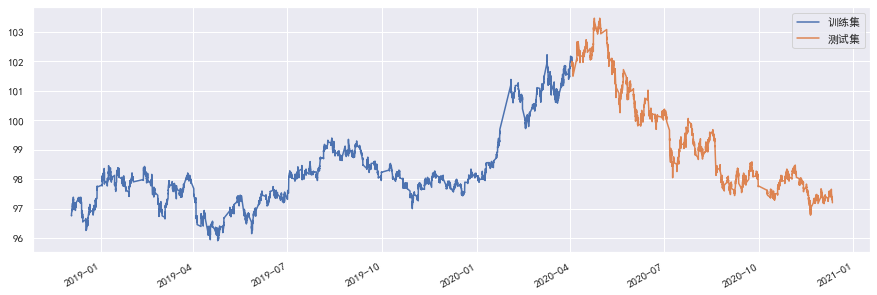

In [109]:
plt.figure(figsize=(15,5))
# plt.subplot(121)
train.close.plot()

test.close.plot()
plt.legend(['训练集','测试集'])
plt.show()

In [69]:
n = 2 # 隐藏状态个数

In [131]:
def pre_process(data):
    volume = data['volume']
    close = data['close']

    logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low'])) #对数价格的高低价差
    logRet_1 = np.array(np.diff(np.log(close))) #  log(Pt/Pt-1)
    logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5])) # 收盘价的五日变化
    logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5])) #交易量的五日变化
    Date = pd.to_datetime(data.index[5:])

    # 保持所有的数据长度相同
    logDel = logDel[5:]
    logRet_1 = logRet_1[4:]
    close = close[5:]
    return logDel,logRet_1,close,logRet_5,logVol_5,Date


def train_model(data):
    """
    传入DataFrame，用来训练模型
    """
    logDel,logRet_1,close,logRet_5,logVol_5,Date=pre_process(data)
    # A = np.column_stack([logDel, logRet_5, logVol_5]) # 传入的参数
    A = np.column_stack([logDel, logRet_5])#, logVol_5]) # 拼接到预期
    
    model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=200000).fit(A) #拟合GaussianHMM
    return model

def model_order(model,data):
    """
    传入模型和DataFrame，
    获得各个隐含状态的排名
    """
    hidden_states = model.predict(A)  # 模型的预测
    logDel,logRet_1,close,logRet_5,logVol_5,Date=pre_process(data)

    templist = [] # 各个策略的最终收益率

    for i in range(n):
        pos = (hidden_states == i)
        pos = np.append(1, pos[:-1])
        res['state_ret%d' % i] = series.multiply(pos)
        data_i = np.exp(res['state_ret%d' % i].cumsum())
        templist.append(data_i[-1])# 得到期末的某一种隐含状态对应的收益率
    templist = np.array(templist).argsort()
    return templist


def result(model,templist,data):    
    """
    传入模型和DataFrame，用模型预测隐含状态，并输出回测结果
    """
    hidden_states = model.predict(A)  # 模型的预测
    logDel,logRet_1,close,logRet_5,logVol_5,Date=pre_process(data)

    plt.figure(figsize=(10, 7))
    for i in range(n):
        pos = (hidden_states == i)
        plt.plot_date(Date[pos], close[pos], 'o', label='hidden state %d' % i, lw=2)
        plt.legend()
    plt.title('各时段隐含状态')
    plt.show()
    res = pd.DataFrame({'Date': Date, 'logReg_1': logRet_1, 'state': hidden_states}).set_index('Date')
    series = res.logReg_1

    templist = [] # 各个策略的最终收益率
    plt.figure(figsize=(10, 7))
    for i in range(n):
        pos = (hidden_states == i)
        pos = np.append(1, pos[:-1])
        res['state_ret%d' % i] = series.multiply(pos)
        data_i = np.exp(res['state_ret%d' % i].cumsum())
        templist.append(data_i[-1])
        plt.plot_date(Date, data_i, '-', label='hidden state %d' % i)
        plt.legend()
    plt.title('各隐含状态对应收益率')
    plt.show()
    
    
    countDict = dict()
    proportitionDict = dict()
    for i in range(n):
        countDict[i] = list(hidden_states).count(i) # 各个状态的数量
        proportitionDict[i] =list(hidden_states).count(i)/len(hidden_states)# 各个状态占比
    
    plt.bar(list(proportitionDict),list(proportitionDict.values()))
    plt.title('各个隐含状态占比')
    plt.show()
    
    templist = np.array(templist).argsort()
    long = (hidden_states == templist[-1]) # 收益好的隐含状态对应买入
    short = (hidden_states == templist[0])  # 空头（卖出）
    long = np.append(0, long[:-1])
    short = np.append(0, short[:-1])

    plt.figure(figsize=(10, 7))
    res['ret'] = series.multiply(long) - series.multiply(short) # 做多做空

    plt.plot_date(Date, np.exp(res['ret'].cumsum()), 'r-',label='策略收益率') # 策略收益函数

    ((data.close)/data.close.iloc[0]).plot(label='指数收益率') # 原收益函数
    plt.title('策略收益率与指数收益率')
    plt.legend()
    

    plt.show()

In [132]:
model=train_model(train) # 使用训练集训练模型


templist=model_order(model,train) # 使用模型得到隐含状态排名

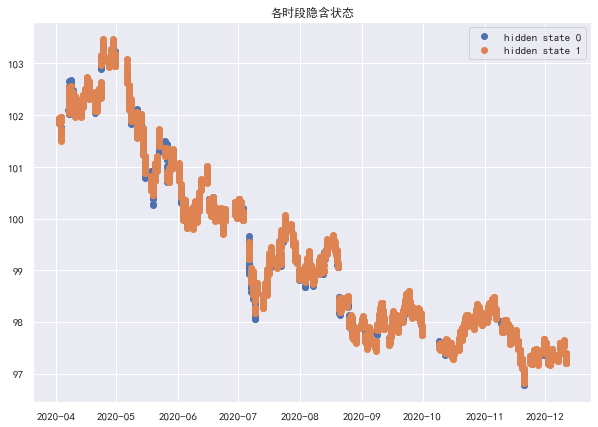

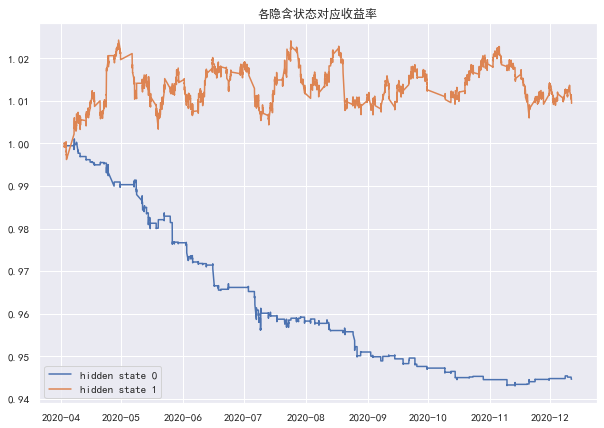

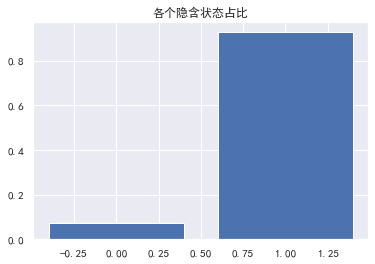

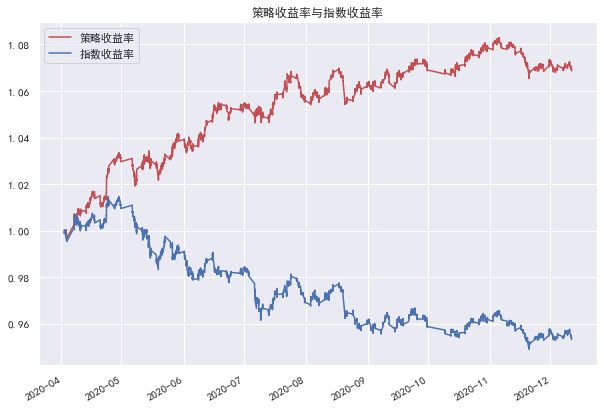

In [133]:
result=result(model,templist,test) # 高收益隐含状态买入，

[[0.98867639 0.01132361]
 [0.21705505 0.78294495]]


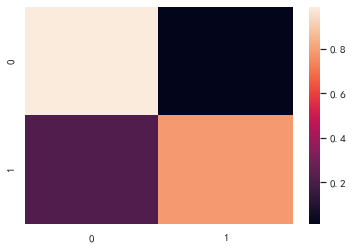

In [72]:
print(model.transmat_)
sns.heatmap(model.transmat_)


In [92]:
data=test
volume = data['volume']
close = data['close']

logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low'])) #对数价格的高低价差
logRet_1 = np.array(np.diff(np.log(close))) #  log(Pt/Pt-1)
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5])) # 收盘价的五日变化
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5])) #交易量的五日变化

# 保持所有的数据长度相同
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]

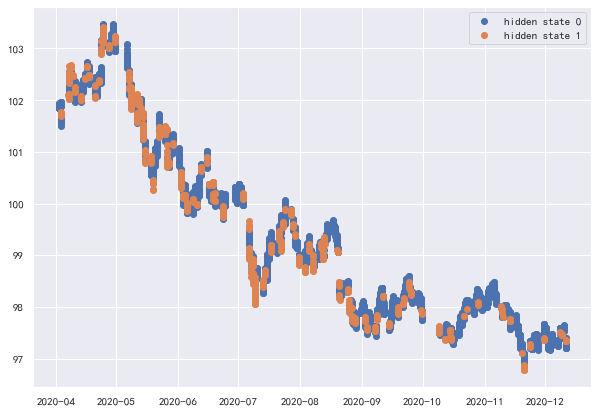

In [111]:
from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

Date = pd.to_datetime(data.index[5:])
# A = np.column_stack([logDel, logRet_5, logVol_5]) # 拼接到预期
A = np.column_stack([logDel, logRet_5])#, logVol_5]) # 拼接到预期

# model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=200000).fit(A) #拟合GaussianHMM
hidden_states = model.predict(A)  # 模型的预测

plt.figure(figsize=(10, 7))
for i in range(n):
    pos = (hidden_states == i)
    plt.plot_date(Date[pos], close[pos], 'o', label='hidden state %d' % i, lw=2)
    plt.legend()
plt.show()

In [94]:
templist

array([1, 0], dtype=int64)

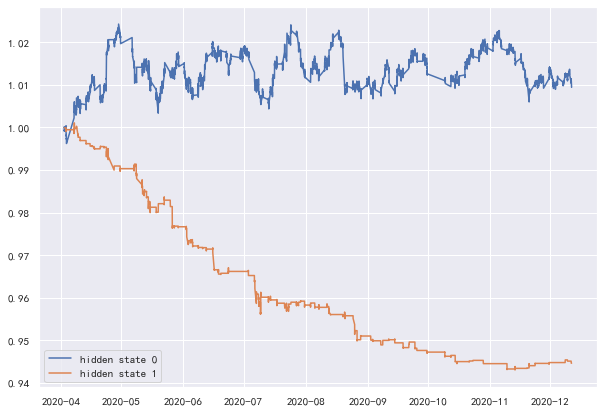

{0: 8208, 1: 643}
{0: 0.9273528414868376, 1: 0.07264715851316235}
0.9273528414868376


<BarContainer object of 2 artists>

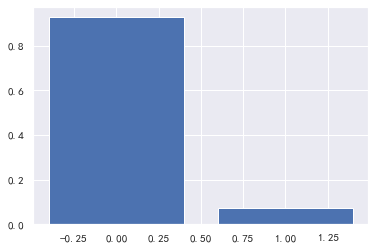

In [95]:
res = pd.DataFrame({'Date': Date, 'logReg_1': logRet_1, 'state': hidden_states}).set_index('Date')
series = res.logReg_1

# templist = [] # 各个策略的最终收益率
plt.figure(figsize=(10, 7))
for i in range(n):
    pos = (hidden_states == i)
    pos = np.append(1, pos[:-1])
    res['state_ret%d' % i] = series.multiply(pos)
    data_i = np.exp(res['state_ret%d' % i].cumsum())
#     templist.append(data_i[-1])
    plt.plot_date(Date, data_i, '-', label='hidden state %d' % i)
    plt.legend()
plt.show()
countDict = dict()
proportitionDict = dict()
 
for i in range(n):
    countDict[i] = list(hidden_states).count(i)
    proportitionDict[i] =list(hidden_states).count(i)/len(hidden_states)

print(countDict)
print(proportitionDict)
print(max(proportitionDict.values()))
plt.bar(list(proportitionDict),list(proportitionDict.values()))

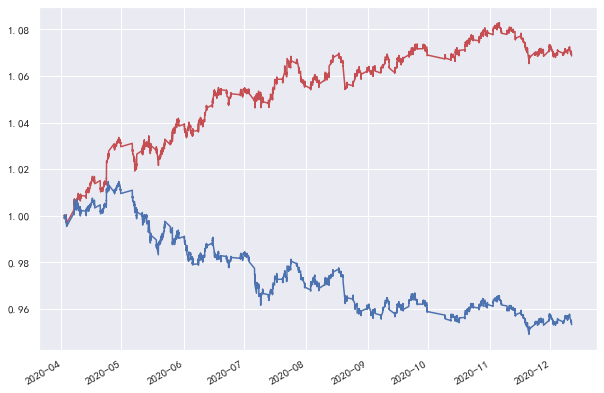

In [97]:
# templist = np.array(templist).argsort()
long = (hidden_states == templist[-1])# + (hidden_states == templist[-2])  # 最优的两种买入
short = (hidden_states == templist[0])# + (hidden_states == templist[1])  # 空头（卖出）
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])

plt.figure(figsize=(10, 7))
res['ret'] = series.multiply(long) - series.multiply(short)

plt.plot_date(Date, np.exp(res['ret'].cumsum()), 'r-')

# plt.plot_date(Date, np.array(np.exp(series.multiply(long).cumsum())), 'b-')
# plt.plot_date(Date, np.array(np.exp((- series.multiply(short).cumsum()))), 'g-')

((test.close)/test.close.iloc[0]).plot()

plt.show()

In [32]:
# pd.concat([np.exp(res['ret']./cumsum()),((test.close)/test.close.iloc[0])],axis=1).to_excel('output.xlsx')

In [33]:
list1 = hidden_states.tolist()

In [34]:
list1.append(None)

In [35]:
len(list1)

8852

In [13]:
def transition(k):
    a = 0
    b = 0
    c = 0
    d = 0
    e = 0
    f = 0
    for i in range(len(list1)-1):
        if list1[i] == k:
            if list1[i+1] == None:
                continue
            elif list1[i+1] == 0:
                a += 1
            elif list1[i+1] == 1:
                b+=1
            elif list1[i+1] == 2:
                c+=1
            elif list1[i+1] == 3:
                d+=1
            elif list1[i+1] == 4:
                e+=1
            elif list1[i+1] == 5:
                f+=1
    return [a/(a+b+c+d+e+f), b/(a+b+c+d+e+f), c/(a+b+c+d+e+f), d/(a+b+c+d+e+f), e/(a+b+c+d+e+f), f/(a+b+c+d+e+f)]

In [14]:
for i in range(6):
    print(transition(i))

[0.8, 0.0, 0.2, 0.0, 0.0, 0.0]
[5.951318216985062e-05, 0.9886329822055585, 0.011247991430101767, 5.951318216985062e-05, 0.0, 0.0]
[0.0, 0.21245828698553948, 0.7875417130144605, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


ZeroDivisionError: division by zero

In [15]:
mat = []
for i in range(6):
    mat.append(transition(i))
    
print(mat)

ZeroDivisionError: division by zero

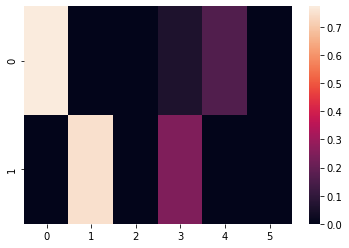

In [142]:
import seaborn as sns
sns.heatmap(mat)

In [95]:
# 模拟数据
i = 2 # 先定一个初始状态
state = []
count = 200000
np.random.seed(666)
ran = np.random.random_sample([count])

for t in range(count):
    r = ran[t]
    if r <= mat[i][0]:
        i = 0
    elif mat[i][0] <= r <= mat[i][0] + mat[i][1]:
        i = 1
    elif mat[i][0] + mat[i][1] <= r <= mat[i][0] + mat[i][1] + mat[i][2]:
        i = 2
    elif mat[i][0] + mat[i][1] + mat[i][2] <= r <= mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3]:
        i = 3
    elif mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3] <= r <= mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3] + mat[i][4]:
        i = 4
    else:
        i = 5
    state.append(i)

In [96]:
countDict = dict()
proportitionDict = dict()
 
for i in range(6):
    countDict[i] = state.count(i)
    proportitionDict[i] = state.count(i)/len(state)

print(countDict)
print(proportitionDict)

{0: 17254, 1: 120826, 2: 15850, 3: 29432, 4: 2872, 5: 13766}
{0: 0.08627, 1: 0.60413, 2: 0.07925, 3: 0.14716, 4: 0.01436, 5: 0.06883}


In [103]:
list(proportitionDict.values())

[0.08627, 0.60413, 0.07925, 0.14716, 0.01436, 0.06883]

<BarContainer object of 6 artists>

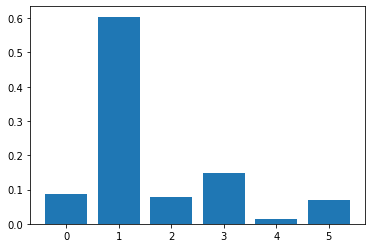

In [105]:
plt.bar(list(proportitionDict),list(proportitionDict.values()))

{0: 4187, 1: 30119, 2: 4048, 3: 7654, 4: 632, 5: 3360}
{0: 0.08374, 1: 0.60238, 2: 0.08096, 3: 0.15308, 4: 0.01264, 5: 0.0672}


<BarContainer object of 6 artists>

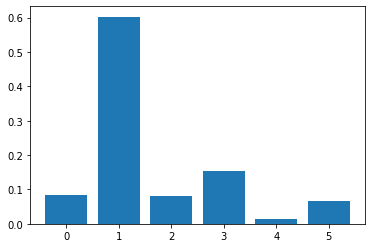

In [107]:
Astate = state[150000:] # 最后5w个数据的情况

countDict1 = dict()
proportitionDict1 = dict()

for i in range(6):
    countDict1[i] = Astate.count(i)
    proportitionDict1[i] = Astate.count(i)/len(Astate)

print(countDict1)
print(proportitionDict1)
plt.bar(list(proportitionDict1),list(proportitionDict1.values()))

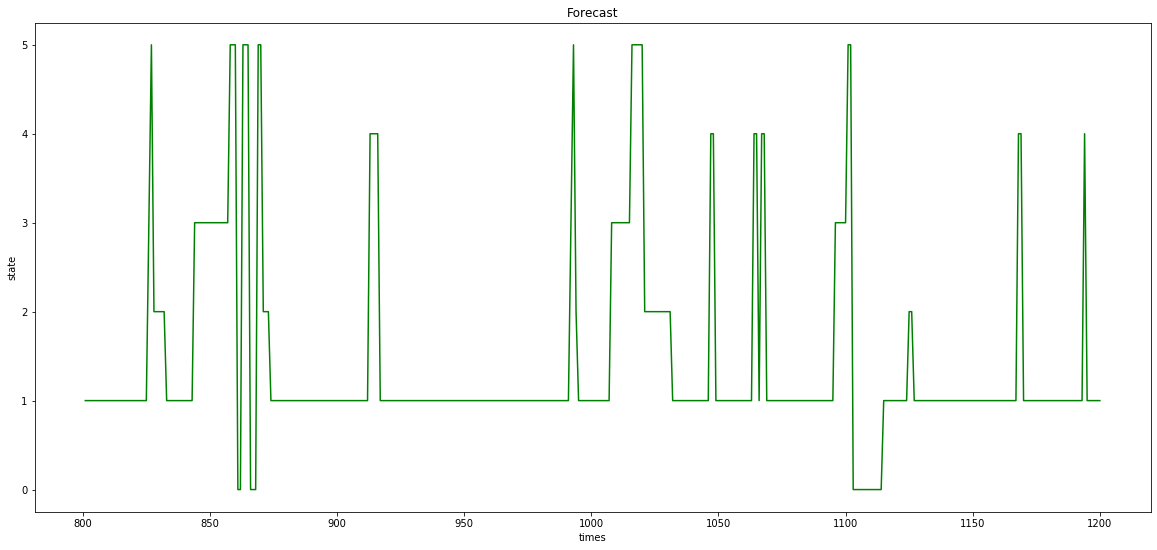

In [92]:
plt.figure(figsize=(20, 9))
plt.title('Forecast')
plt.plot(range(801,1201), state[800:1200], color='green')# 部分状态变动情况
plt.xlabel('times')
plt.ylabel('state')
plt.show()

In [110]:
np.random.randint(17, 20, size=(9,4))

array([[17, 19, 17, 17],
       [18, 19, 19, 17],
       [19, 18, 17, 19],
       [18, 18, 19, 17],
       [19, 19, 17, 19],
       [17, 18, 17, 17],
       [18, 18, 17, 17],
       [17, 19, 19, 17],
       [17, 18, 18, 17]])